# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [339]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [340]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [115]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
IP = "172.26.3.35"
port = 443
url = f"http://{IP}:{port}"

design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
stl_tess = Tesseract.from_url(url)
# stt_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [ ]:
Nx, Ny, Nz = 250, 200, 20
Lx, Ly, Lz = 50, 40, 4

grid_fin_params = {
    "angular_positions": jnp.array(
        [
            [0, 3.14],
            [0.39, 3.53],
            [0.79, 3.93],
            [1.18, 4.32],
            [1.57, 4.71],
            [1.96, 5.11],
            [2.36, 5.50],
            [2.75, 5.89],
        ]
    ),
    "plane_height": 800,
    "plane_thickness": 100,
    "cuttin_plane_1": 400,
    "cuttin_plane_2": 400,
}

# lets create a flat parameter array from the grid fin params
init_diffable_params = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        grid_fin_params["angular_positions"].flatten(),
    ]
).astype(jnp.float32)

normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params = normalize(
    init_diffable_params, normalization_factors, normalization_bias
)

non_diffable_paramas = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_paramas,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe",
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": TesseractReference(stl_tess),
    "grid_center": [0.0, 0.0, 2.0],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": True,
    "epsilon": 1e-2,
}

print(init_diffable_params)

[0.4        0.4        0.         0.99999994 0.12420381 1.1242037
 0.25159234 1.2515923  0.37579614 1.3757961  0.49999997 1.4999999
 0.6242038  1.6273885  0.7515923  1.7515922  0.8757961  1.875796  ]


In [ ]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

Starting Jacobian precomputation thread...
Number of vertices: 248
Number of faces: 564


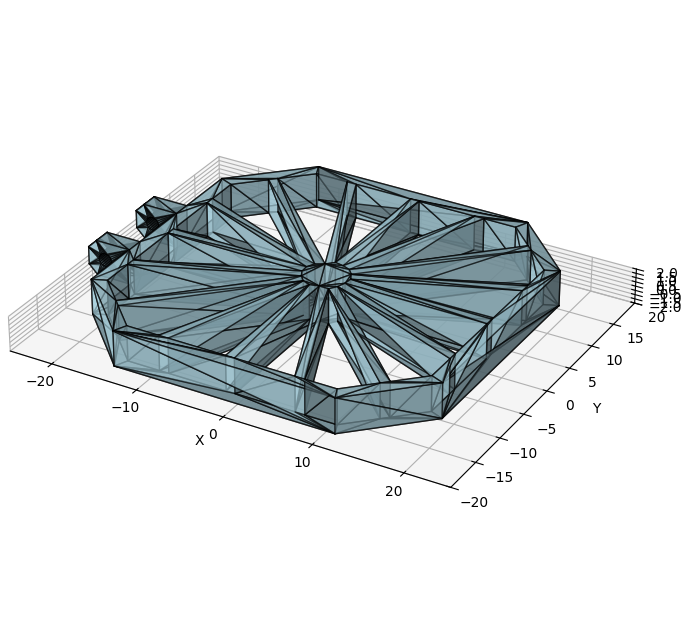

In [ ]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # set equal aspect ratio
    ax.set_box_aspect(
        (
            (Lx) / (Ly),
            1,
            (Lz) / (Ly),
        )
    )

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

In [35]:
# primal, vjp_fun = jax.vjp(
#     lambda params: apply_tesseract(
#         design_tess,
#         {
#             "differentiable_parameters": params,
#             **design_inputs,
#         },
#     )["sdf"],
#     init_diffable_params,
# )

# grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

# print("Gradient shape:", grad.shape)

Starting Jacobian precomputation thread...
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
Gradient shape: (18,)


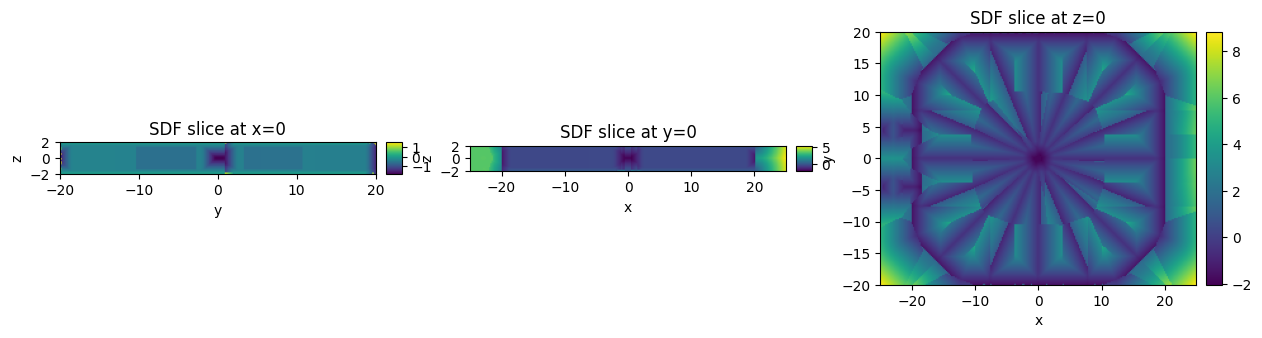

In [92]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

rho min: 0.0009377688984386623, rho max: 0.8489725589752197


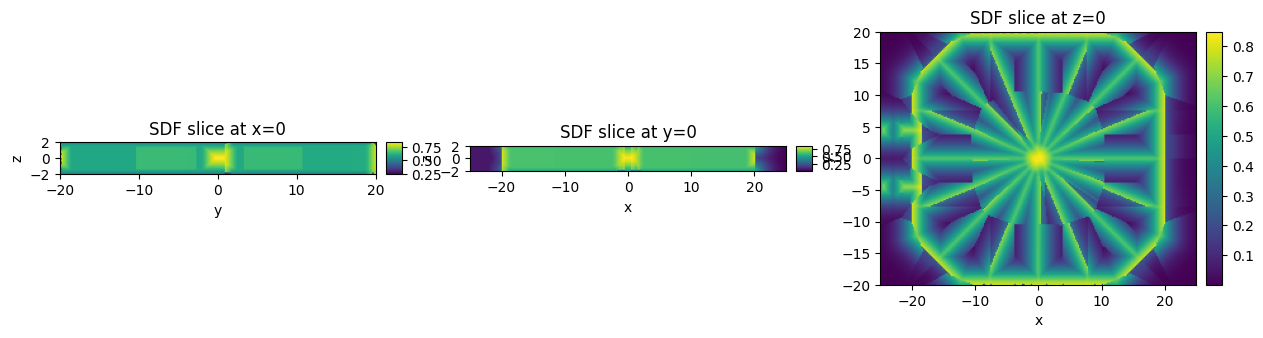

In [93]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 0.8

rho = sdf_to_rho(sdf, scale=rho_scale)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.78125, max: 6.25


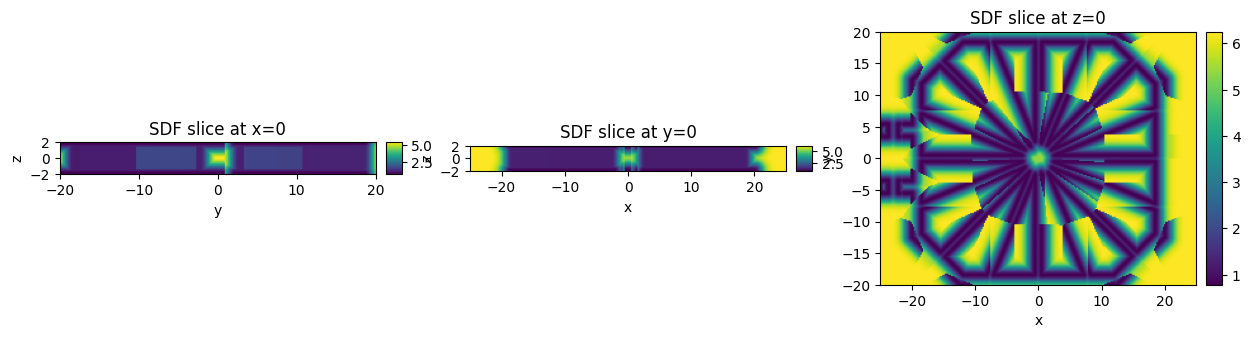

In [94]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 64
sizing_max = Lx / 8
sizing_scale = 1

sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

In [95]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        # "sizing_field": jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 5,
        "max_points": 40000,
        "max_cells": 40000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Mesh points: 4894, Mesh faces: 3648


In [96]:
# Lets export it to a .vtk using pyvista


def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    return pv.UnstructuredGrid(cells, cell_types, pts)


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"])
cells_np = np.array(adaptive_mesh["faces"])

hex_mesh = hex_to_pyvista(pts_np, cells_np)

print(hex_mesh)

hex_mesh.save("fem_shapeopt_mesh.vtk")

UnstructuredGrid (0x7555e15660e0)
  N Cells:    40000
  N Points:   40000
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -2.000e+00, 2.000e+00
  N Arrays:   0


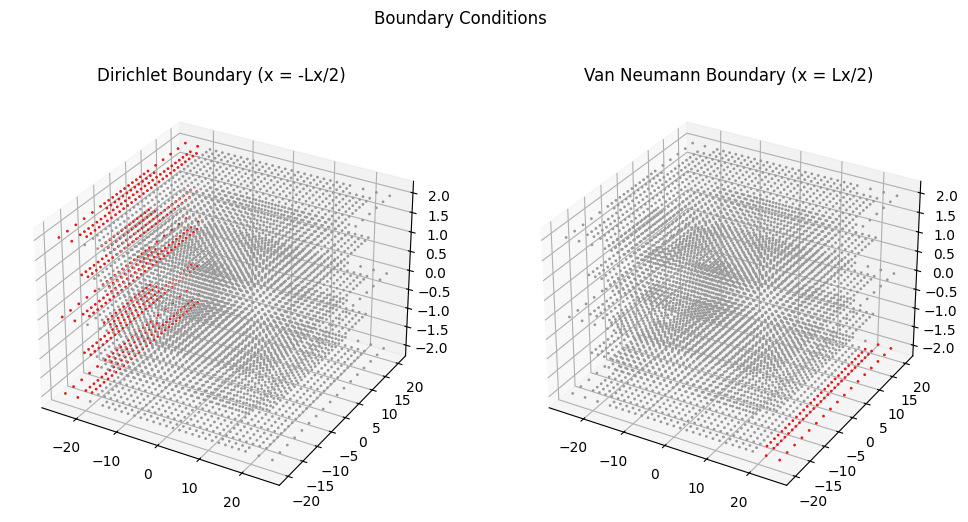

In [97]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 10
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lx / 10),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 10),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

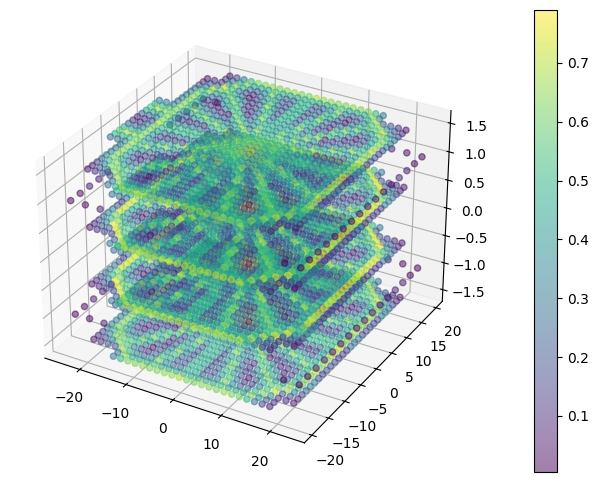

In [98]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [99]:
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [100]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-12 10:53:53][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 10:53:53][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 10:53:53][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-12 10:53:53][DEBUG] jax_fem: Done pre-computations, took 0.6174192428588867 [s]
[11-12 10:53:53][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-12 10:53:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 10:53:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 10:53:53][DEBUG] jax_fem: Start timing
[11-12 10:53:53][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 10:53:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.3023 seconds
[11-12 10:53:54][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 10:53:54][DEBUG] jax_fem: Before, l_2 res = 251.45299198405732, relative l_2 res = 1.0
[11-12 10:53:54][DEBUG] jax_fem: Solving linear system...
[11-12 10:53:54][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-12 10:53:55][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.6444479709987062e-08
[11-12 10:53:55][DEBUG]

Compliance: 79615.0703


In [102]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)


def loss(
    cell_values: jnp.ndarray,
    mesh: dict,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        cell_values: Material density values for each mesh cell.
        mesh: Mesh dictionary.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    mesh = stop_grads_int(mesh)

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": cell_values,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [103]:
# get the gradient of the loss w.r.t. rho
grad_loss = jax.grad(loss)
grad = grad_loss(
    jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1), adaptive_mesh
)
print("Grad shape:", grad.shape)

[11-12 10:54:00][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 10:54:00][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 10:54:00][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-12 10:54:01][DEBUG] jax_fem: Done pre-computations, took 0.6243100166320801 [s]
[11-12 10:54:01][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-12 10:54:01][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 10:54:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 10:54:01][DEBUG] jax_fem: Start timing
[11-12 10:54:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 10:54:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.3045 seconds
[11-12 10:54:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 10:54:01][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 res = 1.0
[11-12 10:54:01][DEBUG] jax_fem: Solving linear system...
[11-12 10:54:01][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-12 10:54:03][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.0578890413786209e-08
[11-12 10:54:03][DEBUG]

Grad shape: (40000, 1)


Voxel center points shape: (3648, 3)
3648


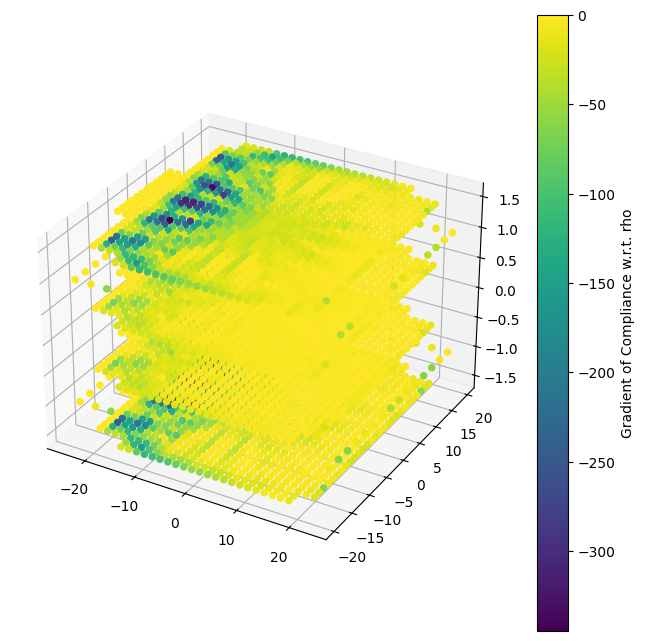

In [104]:
# print a 3D point cloud of the gradient field
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(8, 8))
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
voxel_center_points = jnp.mean(pts_coords[hex_cells], axis=1)
print("Voxel center points shape:", voxel_center_points.shape)
print(mesher_out["mesh"]["n_faces"])
sc = ax.scatter(
    voxel_center_points[:, 0],
    voxel_center_points[:, 1],
    voxel_center_points[:, 2],
    c=grad[: mesher_out["mesh"]["n_faces"], 0],
    cmap="viridis",
    alpha=1.0,
)
# lets add a colorbar
plt.colorbar(sc, ax=ax, label="Gradient of Compliance w.r.t. rho")

In [105]:
max_points = 9000
max_cells = 9000


def loss(
    rho: jnp.ndarray,
) -> float:
    """Compute structural compliance for given bar parameters.

    Args:
        rho: Bar parameter array with shape (n_chains, n_nodes, 3).

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 10.0]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    return c

In [106]:
# get grads of loss w.r.t. rho
grad_loss = jax.grad(loss)
print(rho.shape)
grad = grad_loss(rho)

(250, 200, 20)


[11-12 10:54:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 10:54:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 10:54:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-12 10:54:09][DEBUG] jax_fem: Done pre-computations, took 0.6314103603363037 [s]
[11-12 10:54:09][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-12 10:54:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 10:54:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 10:54:09][DEBUG] jax_fem: Start timing
[11-12 10:54:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 10:54:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.2969 seconds
[11-12 10:54:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 10:54:10][DEBUG] jax_fem: Before, l_2 res = 251.45299198405732, relative l_2 res = 1.0
[11-12 10:54:10][DEBUG] jax_fem: Solving linear system...
[11-12 10:54:10][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-12 10:54:11][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 2.6444479709987062e-08
[11-12 10:54:11][DEBUG]

Grad min: -2154.3657 Grad max: -0.0


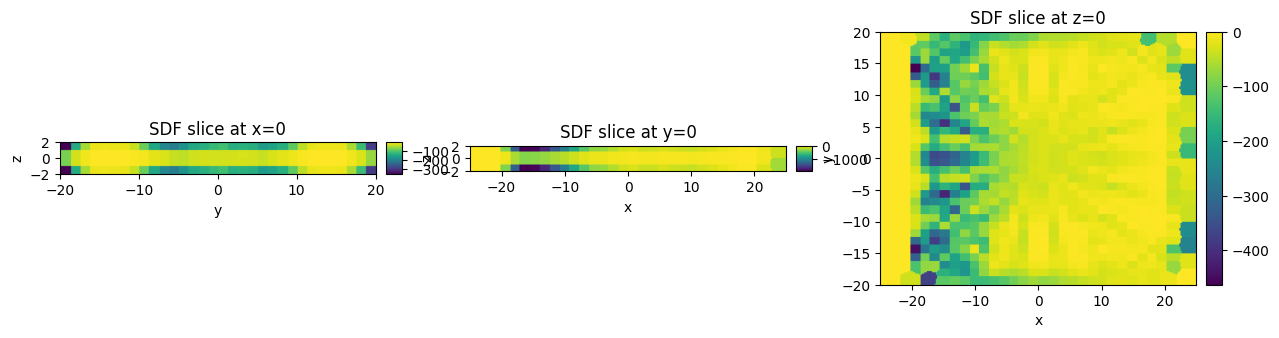

In [107]:
# plot the grad field
plot_grid(grad, Lx, Ly, Lz, Nx, Ny, Nz)
print("Grad min:", jnp.min(grad), "Grad max:", jnp.max(grad))

In [143]:
max_points = 9000
max_cells = 9000


def loss(
    params: jnp.ndarray,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Geometry parameter array.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]

    # Convert SDF to material density distribution
    rho = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    # lets store all intermediate results in a dictionary to return
    # for visualization purposes
    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho": rho,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [148]:
import optax

n_steps = 20
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.01, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adamw(learning_rate=schedule)

params = init_diffable_params.copy()
opt_state = optmizer.init(params)

# params = normalize(init_diffable_params.copy(), normalization_factors)
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss, has_aux=True)

aux_hist = []

for i in range(n_steps):
    print(params)
    (loss_value, aux), grads = grad_fn(params)
    aux_hist.append(aux)

    print(grads)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[..., 0].set(init_diffable_params[..., 0])  # fix x-coordinates

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[0.4        0.4        0.         0.99999994 0.12420381 1.1242037
 0.25159234 1.2515923  0.37579614 1.3757961  0.49999997 1.4999999
 0.6242038  1.6273885  0.7515923  1.7515922  0.8757961  1.875796  ]


[11-12 11:31:03][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:31:03][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:31:03][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:31:04][DEBUG] jax_fem: Done pre-computations, took 0.618065357208252 [s]
[11-12 11:31:04][INFO] jax_fem: Solving a problem with 3648 cells, 4894x3 = 14682 dofs.
[11-12 11:31:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:31:04][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:31:04][DEBUG] jax_fem: Start timing
[11-12 11:31:04][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:31:04][DEBUG] jax_fem: Function split_and_compute_cell took 0.2934 seconds
[11-12 11:31:04][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:31:04][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  5.2571583  12.537776   -5.4825354   3.6617975   4.631421    5.4606385
   4.1112494  -1.6460905 -12.643663    7.559667   -2.6244144  -2.379829
  23.713615  -11.875332   43.839973   24.4618      1.5801582  -5.557782 ]
Iteration 1, Loss: 16628.27
[0.4        0.3899996  0.01       0.98999894 0.11420368 1.1142025
 0.24159208 1.2615911  0.38579577 1.3657947  0.50999945 1.5099983
 0.61420316 1.6373868  0.7415915  1.7415904  0.8657952  1.885794  ]


[11-12 11:31:44][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:31:44][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:31:44][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:31:45][DEBUG] jax_fem: Done pre-computations, took 0.6039016246795654 [s]
[11-12 11:31:45][INFO] jax_fem: Solving a problem with 3578 cells, 4857x3 = 14571 dofs.
[11-12 11:31:45][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:31:45][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:31:45][DEBUG] jax_fem: Start timing
[11-12 11:31:45][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:31:45][DEBUG] jax_fem: Function split_and_compute_cell took 0.3299 seconds
[11-12 11:31:45][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:31:45][DEBUG] jax_fem: Before, l_2 res = 100.58119679362295, relative l_2 r

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  4.0455155  -7.8159394  -7.224489    4.349374    1.0654359   6.8288937
   3.1047444  -2.349287   -9.203633    2.47819    -3.3779407   5.1540084
 -18.26498    -3.9333324 -12.252319    4.3941245  19.123745    1.8351225]
Iteration 2, Loss: 16347.86
[0.4        0.38826102 0.01992571 0.9800426  0.10604772 1.1042576
 0.23181142 1.2714766  0.3955411  1.3571529  0.5199335  1.5060688
 0.6134413  1.6460407  0.737165   1.733719   0.85786855 1.8897991 ]


[11-12 11:32:24][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:32:24][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:32:24][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:32:25][DEBUG] jax_fem: Done pre-computations, took 0.6003937721252441 [s]
[11-12 11:32:25][INFO] jax_fem: Solving a problem with 3536 cells, 4820x3 = 14460 dofs.
[11-12 11:32:25][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:32:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:32:25][DEBUG] jax_fem: Start timing
[11-12 11:32:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:32:25][DEBUG] jax_fem: Function split_and_compute_cell took 0.3233 seconds
[11-12 11:32:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:32:26][DEBUG] jax_fem: Before, l_2 res = 99.66680329822717, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  4.494006   -6.5026784 -12.23591     7.703483   -2.0611396  10.897587
   8.695723   -5.668562    3.693738    6.874239   -2.545306   26.927227
 -65.25673    -4.8487263  11.452209    3.426333   32.337173    4.2408867]
Iteration 3, Loss: 18442.81
[0.4        0.38958573 0.02954801 0.97041065 0.10281219 1.0945418
 0.2225406  1.2805471  0.40137944 1.3479913  0.5297307  1.4992592
 0.6189432  1.6545304  0.7323204  1.7268586  0.8493219  1.8885802 ]


[11-12 11:33:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:33:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:33:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:33:10][DEBUG] jax_fem: Done pre-computations, took 1.0677154064178467 [s]
[11-12 11:33:10][INFO] jax_fem: Solving a problem with 3452 cells, 4779x3 = 14337 dofs.
[11-12 11:33:10][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:33:12][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:33:12][DEBUG] jax_fem: Start timing
[11-12 11:33:12][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:33:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.4793 seconds
[11-12 11:33:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:33:13][DEBUG] jax_fem: Before, l_2 res = 99.66680329822717, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  3.7940183   -3.5245473  -10.560696     4.3256574   -2.3514225
   5.821792     3.3462234   -6.077472     7.6646338    0.10960996
  -1.6324949   14.329842   -87.86456    -12.5703535   16.294134
  -1.4954553   13.6394005   -2.0615654 ]
Iteration 4, Loss: 16457.47
[0.4        0.39186183 0.03925069 0.9609024  0.10277901 1.085033
 0.21357071 1.2898412  0.40320694 1.3404666  0.5390996  1.4916949
 0.62620914 1.6634885  0.7267134  1.7216191  0.8408239  1.8891954 ]


[11-12 11:34:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:34:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:34:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:34:02][DEBUG] jax_fem: Done pre-computations, took 1.0660614967346191 [s]
[11-12 11:34:02][INFO] jax_fem: Solving a problem with 3424 cells, 4766x3 = 14298 dofs.
[11-12 11:34:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:34:02][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:34:02][DEBUG] jax_fem: Start timing
[11-12 11:34:02][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:34:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.3520 seconds
[11-12 11:34:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:34:03][DEBUG] jax_fem: Before, l_2 res = 86.99631816921912, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[   -67.15195 -14917.812     4906.0195  -10946.227    -1180.0681
   2163.7615   -2362.7134    -272.59552  -1692.6677      72.52408
  -1590.6198    5760.591    16472.98     -1105.9072    7510.129
   3663.8198   10204.266     9947.375  ]
Iteration 5, Loss: 47874.25
[0.4        0.3972047  0.03394033 0.9662349  0.10811986 1.0796351
 0.21887766 1.2954301  0.40856355 1.334273   0.5444661  1.4863182
 0.6209096  1.6689523  0.72134054 1.7162462  0.835454   1.8838528 ]


[11-12 11:34:50][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:34:50][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:34:50][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:34:51][DEBUG] jax_fem: Done pre-computations, took 1.0616283416748047 [s]
[11-12 11:34:51][INFO] jax_fem: Solving a problem with 3466 cells, 4796x3 = 14388 dofs.
[11-12 11:34:51][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:34:53][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:34:53][DEBUG] jax_fem: Start timing
[11-12 11:34:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:34:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.5435 seconds
[11-12 11:34:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:34:55][DEBUG] jax_fem: Before, l_2 res = 86.99631816921914, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  2530.4814    3253.0557   -2130.019   -12137.859      485.74805
  -5719.024      -76.68799 -27747.71      1369.543     2545.957
  -6525.202    28015.941    43772.953   -22307.666    11056.865
  10756.309   -13275.754     -261.3368 ]
Iteration 6, Loss: -29248.47
[0.4        0.40059602 0.03179059 0.9730729  0.11041725 1.0827541
 0.22359015 1.3005611  0.40893337 1.3290356  0.5504957  1.4804077
 0.6145497  1.6742618  0.71454537 1.7099464  0.83668154 1.8794074 ]


[11-12 11:35:48][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:35:48][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:35:48][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:35:49][DEBUG] jax_fem: Done pre-computations, took 1.0492405891418457 [s]
[11-12 11:35:49][INFO] jax_fem: Solving a problem with 3438 cells, 4781x3 = 14343 dofs.
[11-12 11:35:49][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:35:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:35:51][DEBUG] jax_fem: Start timing
[11-12 11:35:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:35:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.5110 seconds
[11-12 11:35:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:35:52][DEBUG] jax_fem: Before, l_2 res = 86.99631816921912, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  639.5498    623.56775  -482.24783  -659.16974 -3923.8457    418.6317
   649.0913   1031.5449  -1386.3586   3878.2815  -2123.9194   4311.7905
  4605.119    1337.845    1353.4574   2053.1      3734.0366   1216.8289 ]
Iteration 7, Loss: 32354.96
[0.4        0.4033392  0.03037162 0.979206   0.11569999 1.0851219
 0.22623728 1.3048328  0.41184074 1.3224368  0.55696964 1.4745986
 0.6085703  1.6785723  0.7081777  1.7036879  0.83665365 1.8749778 ]


[11-12 11:36:45][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:36:45][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:36:45][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:36:46][DEBUG] jax_fem: Done pre-computations, took 1.0651416778564453 [s]
[11-12 11:36:46][INFO] jax_fem: Solving a problem with 3382 cells, 4746x3 = 14238 dofs.
[11-12 11:36:46][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:36:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:36:47][DEBUG] jax_fem: Start timing
[11-12 11:36:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:36:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.5088 seconds
[11-12 11:36:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:36:48][DEBUG] jax_fem: Before, l_2 res = 99.66680329822717, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[ 4.82249069e+00 -3.16474390e+00 -1.07140141e+01 -7.83261657e-01
 -8.60280228e+00  6.96253920e+00 -6.61451817e-02 -4.83553696e+00
  1.17555749e+00 -4.17303181e+00 -3.06591225e+00 -9.81779480e+00
 -1.21610275e+02 -1.26732330e+01  6.63337660e+00 -3.93591475e+00
 -3.31277237e+01 -9.08718777e+00]
Iteration 8, Loss: 18557.59
[0.4        0.40574571 0.02913684 0.98458445 0.12034252 1.0871927
 0.22855873 1.3085796  0.41438806 1.3166542  0.56264883 1.469506
 0.6033391  1.6823548  0.70259124 1.6982011  0.83663833 1.8710976 ]


[11-12 11:37:37][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:37:37][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:37:37][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:37:38][DEBUG] jax_fem: Done pre-computations, took 1.077441930770874 [s]
[11-12 11:37:38][INFO] jax_fem: Solving a problem with 3424 cells, 4776x3 = 14328 dofs.
[11-12 11:37:38][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:37:38][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:37:38][DEBUG] jax_fem: Start timing
[11-12 11:37:38][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:37:39][DEBUG] jax_fem: Function split_and_compute_cell took 0.3561 seconds
[11-12 11:37:39][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:37:39][DEBUG] jax_fem: Before, l_2 res = 86.99631816921912, relative l_2 res

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[ 1425.5466   -2308.483     1490.9808   12815.414    -4264.4434
 16470.238      370.20563   2088.4014      27.856705   178.46338
 -2753.9177    2402.6567     -65.00789  -1386.9064      32.85399
 -2581.1807    7155.9297   12951.117   ]
Iteration 9, Loss: 8961.20
[0.4        0.40854815 0.02683053 0.98542756 0.12656093 1.0834364
 0.22988462 1.3115268  0.4165867  1.3113711  0.56902707 1.4646357
 0.598726   1.6859788  0.6976465  1.6944963  0.83481926 1.8652937 ]


[11-12 11:38:23][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:38:23][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:38:23][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:38:24][DEBUG] jax_fem: Done pre-computations, took 1.1073880195617676 [s]
[11-12 11:38:24][INFO] jax_fem: Solving a problem with 3424 cells, 4786x3 = 14358 dofs.
[11-12 11:38:24][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:38:24][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:38:24][DEBUG] jax_fem: Start timing
[11-12 11:38:24][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:38:24][DEBUG] jax_fem: Function split_and_compute_cell took 0.3761 seconds
[11-12 11:38:25][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:38:25][DEBUG] jax_fem: Before, l_2 res = 86.99631816921912, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[   591.83246  -1927.0841    1882.5327    8123.4507  -18376.373
   4407.648     -261.36124  -3298.314     2201.0945    -383.15607
   -660.87476  -1721.2446   -3885.1304    1623.3251   -5343.629
  -1658.3739    4935.499     2835.7302 ]
Iteration 10, Loss: 17046.52
[0.4        0.4115899  0.02340967 0.98444    0.1326525  1.0790771
 0.23154068 1.3146694  0.41506946 1.3070772  0.5750708  1.4605935
 0.59502584 1.6888531  0.6952792  1.6918815  0.83207077 1.8594276 ]


[11-12 11:39:08][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:39:08][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:39:08][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:39:09][DEBUG] jax_fem: Done pre-computations, took 1.09513521194458 [s]
[11-12 11:39:09][INFO] jax_fem: Solving a problem with 3466 cells, 4806x3 = 14418 dofs.
[11-12 11:39:09][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:39:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:39:09][DEBUG] jax_fem: Start timing
[11-12 11:39:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:39:10][DEBUG] jax_fem: Function split_and_compute_cell took 0.3676 seconds
[11-12 11:39:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:39:10][DEBUG] jax_fem: Before, l_2 res = 86.99631816921914, relative l_2 res 

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  -250.74931    -185.77783    2176.581    -13006.393    -16123.187
   5841.2476      112.785866    593.8051    13982.7705    -2634.3706
   -744.69165    2458.213     -1496.5491      -83.329414    267.3003
   3798.497      -359.45062   15031.628   ]
Iteration 11, Loss: 10584.51
[0.4        0.414356   0.01895969 0.98598635 0.13975249 1.0739737
 0.23280817 1.317373   0.41030535 1.3060014  0.5808803  1.4566163
 0.5918743  1.6914324  0.6930843  1.6882715  0.82970655 1.8524804 ]


[11-12 11:39:57][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:39:57][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:39:57][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:39:58][DEBUG] jax_fem: Done pre-computations, took 1.083078384399414 [s]
[11-12 11:39:58][INFO] jax_fem: Solving a problem with 3480 cells, 4823x3 = 14469 dofs.
[11-12 11:39:58][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:39:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:39:59][DEBUG] jax_fem: Start timing
[11-12 11:39:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:40:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.2567 seconds
[11-12 11:40:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:40:00][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  7.8499546   -6.9961567   -8.25633     -3.7288008    3.8578389
  10.977547     0.6948955   -1.7939494  -10.252511     1.1944832
  -2.7071986   -6.326738   -45.938084     0.10596552 -40.578346
  -5.7843037   24.710178    -4.487003  ]
Iteration 12, Loss: 17815.79
[0.4        0.41683203 0.01498557 0.98736995 0.14610209 1.0694064
 0.23394054 1.3197914  0.4060475  1.3050381  0.58607787 1.4530599
 0.58905995 1.693739   0.6911339  1.6850446  0.82758605 1.8462676 ]


[11-12 11:40:52][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:40:52][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:40:52][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:40:53][DEBUG] jax_fem: Done pre-computations, took 1.0713996887207031 [s]
[11-12 11:40:53][INFO] jax_fem: Solving a problem with 3487 cells, 4826x3 = 14478 dofs.
[11-12 11:40:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:40:55][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:40:55][DEBUG] jax_fem: Start timing
[11-12 11:40:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:40:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.4741 seconds
[11-12 11:40:56][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:40:56][DEBUG] jax_fem: Before, l_2 res = 100.58119679362295, relative l_2 r

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  6.6342773   -5.528713    -6.4746056   -4.7362304   -3.3435853
  11.531216    -1.4917713   -2.6780953   -0.77009857  -4.312361
  -2.3605535  -15.976879   -41.657417     5.0573883  -54.19516
  -3.6563604   37.110672    -4.128832  ]
Iteration 13, Loss: 17357.19
[0.4        0.41905403 0.01142641 0.98861146 0.15179676 1.0653077
 0.2349587  1.3219604  0.4022294  1.3041778  0.59074026 1.449873
 0.5865401  1.6958065  0.6894018  1.682152   0.82567567 1.8406968 ]


[11-12 11:41:48][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:41:48][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:41:48][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:41:49][DEBUG] jax_fem: Done pre-computations, took 1.070451021194458 [s]
[11-12 11:41:49][INFO] jax_fem: Solving a problem with 3473 cells, 4821x3 = 14463 dofs.
[11-12 11:41:49][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:41:51][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:41:51][DEBUG] jax_fem: Start timing
[11-12 11:41:51][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:41:51][DEBUG] jax_fem: Function split_and_compute_cell took 0.4817 seconds
[11-12 11:41:52][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:41:52][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  7.133086    -7.1775784   -8.496975    -4.466218     1.3737168
  14.547623    -0.12257591  -3.340697    -9.380501    -1.5951436
  -2.4702213    2.8505325  -59.38903     -0.07810619 -33.20925
  -3.0453205   30.802235    -3.9289975 ]
Iteration 14, Loss: 16789.17
[0.4        0.42105293 0.00823404 0.98972785 0.15691414 1.0616208
 0.23587388 1.3239101  0.39880112 1.3034059  0.5949316  1.4470084
 0.5842812  1.6976643  0.6878556  1.6795535  0.8239515  1.8356911 ]


[11-12 11:42:41][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:42:41][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:42:41][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:42:42][DEBUG] jax_fem: Done pre-computations, took 1.0893630981445312 [s]
[11-12 11:42:42][INFO] jax_fem: Solving a problem with 3473 cells, 4809x3 = 14427 dofs.
[11-12 11:42:42][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:42:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:42:42][DEBUG] jax_fem: Start timing
[11-12 11:42:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:42:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.3281 seconds
[11-12 11:42:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:42:43][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 r

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[ 5.1197863e+00 -4.3644161e+00 -7.4638696e+00 -2.1196470e+00
 -6.3543949e+00  1.2239701e+01  3.8172007e-02 -3.2301817e+00
  6.6125388e+00 -3.9015441e+00 -1.7361609e+00 -6.9635277e+00
 -5.5350803e+01  4.4731684e+00 -4.9560074e+01 -1.1254630e+00
  3.7463463e+01 -6.4584804e-01]
Iteration 15, Loss: 15991.20
[0.4        0.42285362 0.0053656  0.99073315 0.16152206 1.0582988
 0.23669766 1.3256657  0.3957128  1.3027141  0.5987057  1.4444306
 0.582253   1.6993356  0.68647915 1.6772145  0.82239044 1.8311849 ]


[11-12 11:43:25][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:43:25][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:43:25][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:43:26][DEBUG] jax_fem: Done pre-computations, took 1.0960884094238281 [s]
[11-12 11:43:26][INFO] jax_fem: Solving a problem with 3487 cells, 4819x3 = 14457 dofs.
[11-12 11:43:26][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:43:27][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:43:27][DEBUG] jax_fem: Start timing
[11-12 11:43:27][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:43:27][DEBUG] jax_fem: Function split_and_compute_cell took 0.3205 seconds
[11-12 11:43:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:43:27][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 r

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  5.175252    -4.069189    -7.908065    -2.4318018   -6.242796
  11.830484    -0.79759836  -3.0240917    6.815347    -4.600537
  -1.4222791   -1.914436   -52.075985     4.084671   -47.41957
  -0.9751935   35.461517    -1.5755898 ]
Iteration 16, Loss: 15898.80
[0.4        0.42447808 0.00278545 0.99163973 0.16567716 1.0553012
 0.23744172 1.3272487  0.3929265  1.3020943  0.60210884 1.442107
 0.58042955 1.7008413  0.68525314 1.675106   0.82097477 1.8271227 ]


[11-12 11:44:10][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:44:10][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:44:10][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:44:11][DEBUG] jax_fem: Done pre-computations, took 1.1084067821502686 [s]
[11-12 11:44:11][INFO] jax_fem: Solving a problem with 3480 cells, 4815x3 = 14445 dofs.
[11-12 11:44:11][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:44:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:44:11][DEBUG] jax_fem: Start timing
[11-12 11:44:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:44:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.1764 seconds
[11-12 11:44:12][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:44:12][DEBUG] jax_fem: Before, l_2 res = 100.58119679362295, relative l_2 r

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  5.0104966   -3.755452    -7.485656    -2.4858813   -6.1401005
  11.449486    -0.87766755  -3.099771     8.072542    -4.392953
  -1.5607033    1.1721596  -48.2832       3.291512   -44.655403
   0.11119455  34.278355    -1.3205423 ]
Iteration 17, Loss: 15862.64
[4.0000001e-01 4.2594525e-01 4.6223053e-04 9.9245828e-01 1.6942833e-01
 1.0525929e+00 2.3811483e-01 1.3286778e+00 3.9040923e-01 1.3015386e+00
 6.0518116e-01 1.4400095e+00 5.7878846e-01 1.7021995e+00 6.8416065e-01
 1.6732030e+00 8.1968886e-01 1.8234565e+00]


[11-12 11:44:58][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:44:58][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:44:58][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:44:59][DEBUG] jax_fem: Done pre-computations, took 1.0792076587677002 [s]
[11-12 11:44:59][INFO] jax_fem: Solving a problem with 3459 cells, 4798x3 = 14394 dofs.
[11-12 11:44:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:45:01][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:45:01][DEBUG] jax_fem: Start timing
[11-12 11:45:01][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:45:01][DEBUG] jax_fem: Function split_and_compute_cell took 0.4846 seconds
[11-12 11:45:02][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:45:02][DEBUG] jax_fem: Before, l_2 res = 100.58119679362294, relative l_2 r

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  5.2842975   -4.172587    -8.757034    -2.9336052   -7.6256194
  12.657116    -1.3065569   -3.0279222    9.153186    -3.1880798
  -0.80834746   2.5137186  -48.78385      4.047659   -50.424847
  -5.240446    46.31019     -0.8843156 ]
Iteration 18, Loss: 17363.44
[ 4.0000001e-01  4.2727184e-01 -1.6301239e-03  9.9319822e-01
  1.7281842e-01  1.0501431e+00  2.3872529e-01  1.3299692e+00
  3.8813224e-01  1.3010391e+00  6.0795701e-01  1.4381142e+00
  5.7731062e-01  1.7034254e+00  6.8318957e-01  1.6714855e+00
  8.1851614e-01  1.8201447e+00]


[11-12 11:45:55][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:45:55][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:45:55][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:45:56][DEBUG] jax_fem: Done pre-computations, took 1.080742359161377 [s]
[11-12 11:45:56][INFO] jax_fem: Solving a problem with 3431 cells, 4762x3 = 14286 dofs.
[11-12 11:45:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:45:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:45:57][DEBUG] jax_fem: Start timing
[11-12 11:45:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:45:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.4825 seconds
[11-12 11:45:58][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:45:58][DEBUG] jax_fem: Before, l_2 res = 100.58119679362295, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  8.078346    -6.2683463   -8.049753    -5.014064    -6.0452185
  13.362725    -4.683058    -2.4815962   -0.09114501  -5.178732
  -2.6331592   -2.6030035    4.831852     3.174992   -47.952152
 -14.005209    49.23545     -3.4285064 ]
Iteration 19, Loss: 19001.19
[ 0.4         0.428473   -0.00351586  0.99386793  0.17588438  1.0479251
  0.23928578  1.331137    0.38607368  1.300592    0.61046815  1.436401
  0.57597405  1.704533    0.68232685  1.6699378   0.8174441   1.8171511 ]


[11-12 11:46:52][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-12 11:46:52][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-12 11:46:52][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-12 11:46:53][DEBUG] jax_fem: Done pre-computations, took 1.0753769874572754 [s]
[11-12 11:46:53][INFO] jax_fem: Solving a problem with 3417 cells, 4740x3 = 14220 dofs.
[11-12 11:46:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-12 11:46:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-12 11:46:54][DEBUG] jax_fem: Start timing
[11-12 11:46:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-12 11:46:55][DEBUG] jax_fem: Function split_and_compute_cell took 0.5193 seconds
[11-12 11:46:56][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-12 11:46:56][DEBUG] jax_fem: Before, l_2 res = 86.99631816921912, relative l_2 re

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 20) and type: float32
[  -137.87051   -4452.5684    -1469.0996     1317.2192   -10346.266
     76.96567   -1138.751      -268.6848     1251.5077    -2190.9631
   -156.5943     1045.3821     -106.24473     -42.910233  -1470.0756
  -3517.5552     5975.031      5719.2666  ]
Iteration 20, Loss: 9714.88


Text(0.5, 1.0, 'Compliance over Optimization')

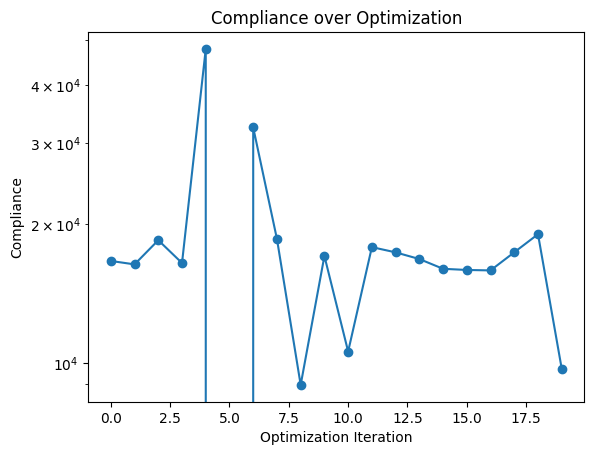

In [149]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [150]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=2).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_sum_2.gif", writer="pillow", fps=10)

In [147]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")